In [1]:
# Cell 2: Import libraries

from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
import json
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load the main scraped results
print("="*60)
print("SENTIMENT ANALYSIS ON SCRAPED ARTICLES")
print("="*60)

from pathlib import Path

input_file = '../data/processed/global_cleaned.json'
with open(input_file, 'r', encoding='utf-8') as f:
    full_data = json.load(f)

# Extract articles from the structure
articles = full_data.get('all_articles', [])
print(f"✓ Loaded {len(articles)} articles for analysis")

# Preview structure
if articles:
    print("\nSample article structure:")
    sample = articles[0]
    print(f"Keys: {list(sample.keys())}")
    print(f"Sample headline: {sample.get('headline', 'N/A')[:80]}...")
    print(f"Sample tickers: {sample.get('tickers', 'N/A')}")

SENTIMENT ANALYSIS ON SCRAPED ARTICLES
✓ Loaded 4626 articles for analysis

Sample article structure:
Keys: ['id', 'headline', 'content', 'date', 'url', 'tickers', 'language']
Sample headline: la biat et la bad signent une convention de 50 millions de dollars en faveur des...
Sample tickers: ['BIAT']


In [ ]:
# Initialize the sentiment analysis pipeline
from transformers import pipeline
import torch

model_path = "../src/models/xlm-roberta-tunisian-finance-final"

print(f"\n🤖 Loading trained model from: {model_path}")

# Create sentiment pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model_path,
    tokenizer=model_path,
    device=0 if torch.cuda.is_available() else -1,  # Use GPU if available
    max_length=256,
    truncation=True
)

print("✓ Model loaded successfully!")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")


🤖 Loading trained model from: ../src/models/xlm-roberta-tunisian-finance-final


Device set to use cpu


✓ Model loaded successfully!
Device: CPU


In [4]:
labels_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

def parse_model_output(result):
    """
    Convert model prediction to sentiment score.
    The model already returns -1/0/1 directly, no mapping needed!
    """
    try:
        if isinstance(result, dict):
            label = result.get('label')
            
            # Label is already the sentiment score (-1, 0, or 1)
            if isinstance(label, (int, float)):
                # Ensure it's a valid sentiment score
                if label in [-1, 0, 1]:
                    return int(label)
                else:
                    print(f"⚠️ Unexpected label value: {label}")
                    return 0
            
            # Fallback: string format "LABEL_X"
            elif isinstance(label, str):
                if label == 'LABEL_0' or label == '-1':
                    return -1
                elif label == 'LABEL_1' or label == '0':
                    return 0
                elif label == 'LABEL_2' or label == '1':
                    return 1
        
        # Direct integer/float
        elif isinstance(result, (int, float)):
            if result in [-1, 0, 1]:
                return int(result)
        
        return 0
            
    except Exception as e:
        print(f"⚠️ Parse error: {e}, result={result}")
        return 0

print("✓ Label mapping configured - NO INVERSE MAPPING!")

# Test it
test_cases = [
    {'label': -1, 'score': 0.95},  # Negative
    {'label': 0, 'score': 0.85},   # Neutral
    {'label': 1, 'score': 0.73},   # Positive
]

for test in test_cases:
    parsed = parse_model_output(test)
    print(f"{test} → {parsed} ({labels_map[parsed]})")

✓ Label mapping configured - NO INVERSE MAPPING!
{'label': -1, 'score': 0.95} → -1 (Negative)
{'label': 0, 'score': 0.85} → 0 (Neutral)
{'label': 1, 'score': 0.73} → 1 (Positive)


In [ ]:
# Return both labels and confidence scores
def predict_sentiments_batch(texts, batch_size=16, desc="Processing"):
    """
    Process texts in batches for efficiency.
    Returns: (list of sentiment scores, list of confidence scores)
    """
    from tqdm import tqdm
    
    sentiment_scores = []
    confidence_scores = []
    
    # Progress bar
    num_batches = (len(texts) + batch_size - 1) // batch_size
    
    for i in tqdm(range(0, len(texts), batch_size), total=num_batches, desc=desc):
        batch = texts[i:i+batch_size]
        
        # Prepare batch (handle empty/None texts)
        processed_batch = []
        valid_indices = []
        
        for idx, text in enumerate(batch):
            if text and isinstance(text, str) and len(text.strip()) >= 5:
                processed_batch.append(text[:512])
                valid_indices.append(idx)
        
        # Initialize with neutral/low confidence
        batch_sentiments = [0] * len(batch)
        batch_confidences = [0.0] * len(batch)
        
        try:
            if processed_batch:
                results = sentiment_analyzer(processed_batch)
                
                # Map results back to original batch positions
                for result_idx, batch_idx in enumerate(valid_indices):
                    result = results[result_idx]
                    sentiment_score = parse_model_output(result)
                    # Get the confidence score from the model
                    conf_score = result.get('score', 0.5) if isinstance(result, dict) else 0.5
                    
                    batch_sentiments[batch_idx] = sentiment_score
                    batch_confidences[batch_idx] = conf_score
                    
        except Exception as e:
            print(f"\n⚠️ Batch error at index {i}: {str(e)}")
        
        sentiment_scores.extend(batch_sentiments)
        confidence_scores.extend(batch_confidences)
    
    return sentiment_scores, confidence_scores

In [ ]:
# Extract and prepare texts from articles
print("\n📝 Preparing texts for analysis...")

# Handle both string and list formats for content
headlines = []
contents = []

for article in articles:
    # Extract headline
    headline = article.get('headline', '')
    headlines.append(headline if headline else '')
    
    # Extract content (handle different formats)
    content = article.get('content', '')
    if isinstance(content, list):
        # Join list of paragraphs
        content = ' '.join([p for p in content if p])
    elif not isinstance(content, str):
        content = str(content) if content else ''
    
    contents.append(content)

print(f"✓ Prepared {len(headlines)} headlines")
print(f"✓ Prepared {len(contents)} content texts")

# Validate
empty_headlines = sum(1 for h in headlines if not h or len(h.strip()) < 5)
empty_contents = sum(1 for c in contents if not c or len(c.strip()) < 5)
print(f"  - Empty/short headlines: {empty_headlines}")
print(f"  - Empty/short contents: {empty_contents}")


📝 Preparing texts for analysis...
✓ Prepared 4626 headlines
✓ Prepared 4626 content texts
  - Empty/short headlines: 0
  - Empty/short contents: 0


In [ ]:
# Get both scores and confidences
print("\n" + "="*60)
print("RUNNING SENTIMENT ANALYSIS")
print("="*60)

print("\n🤖 Analyzing Headlines (Primary Signal)...")
headline_scores, headline_confidences = predict_sentiments_batch(headlines, batch_size=16, desc="Headlines")

print("\n🔍 Analyzing Content (Detailed Context)...")
content_scores, content_confidences = predict_sentiments_batch(contents, batch_size=16, desc="Content")

print("\n✅ Inference completed!")



RUNNING SENTIMENT ANALYSIS

🤖 Analyzing Headlines (Primary Signal)...


Headlines: 100%|██████████| 290/290 [04:04<00:00,  1.18it/s]



🔍 Analyzing Content (Detailed Context)...


Content: 100%|██████████| 290/290 [14:35<00:00,  3.02s/it]


✅ Inference completed!


In [ ]:
# Combine model confidence with agreement logic
print("\n⚙️ Applying sentiment aggregation logic...")

for i, article in enumerate(articles):
    h_score = headline_scores[i]
    c_score = content_scores[i]
    h_conf = headline_confidences[i]
    c_conf = content_confidences[i]
    
    # COMBINED CONFIDENCE CALCULATION:
    # Base confidence = model's confidence score
    # Boost if both agree, penalize if they disagree
    
    if h_score != 0:
        # Headline has clear sentiment
        if c_score == h_score:
            # Both agree - use max confidence, boost by 10%
            final_sentiment = h_score
            confidence = min(1.0, max(h_conf, c_conf) * 1.1)
        elif c_score == 0:
            # Content is neutral - use headline confidence as-is
            final_sentiment = h_score
            confidence = h_conf
        else:
            # They disagree - use headline but penalize confidence by 30%
            final_sentiment = h_score
            confidence = h_conf * 0.7
    else:
        # Headline is neutral - use content
        final_sentiment = c_score
        if c_score != 0:
            confidence = c_conf * 0.8  # Slight penalty for neutral headline
        else:
            confidence = max(h_conf, c_conf) * 0.5  # Both neutral - low confidence
    
    # Store enriched results
    article['sentiment_score'] = int(final_sentiment)
    #article['sentiment_label'] = labels_map[final_sentiment]
    #article['headline_sentiment'] = int(h_score)
    #article['content_sentiment'] = int(c_score)
    #article['headline_confidence'] = round(h_conf, 3)
    #article['content_confidence'] = round(c_conf, 3)
    article['confidence'] = round(confidence, 3)

print("✅ Sentiment enrichment complete!")


⚙️ Applying sentiment aggregation logic...
✅ Sentiment enrichment complete!


In [ ]:
# Preview results
print("\n" + "="*80)
print("SAMPLE RESULTS")
print("="*80)

for i, a in enumerate(articles[:5]):
    print(f"\n[Article {i+1}]")
    print(f"Date: {a.get('date', 'N/A')}")
    print(f"Source: {a.get('source', 'N/A')}")
    print(f"Tickers: {a.get('tickers', 'N/A')}")
    print(f"Headline: {a.get('headline', '')[:80]}...")

    print("-"*80)


SAMPLE RESULTS

[Article 1]
Date: 2026-02-06
Source: N/A
Tickers: ['BIAT']
Headline: la biat et la bad signent une convention de 50 millions de dollars en faveur des...
--------------------------------------------------------------------------------

[Article 2]
Date: 2026-02-06
Source: N/A
Tickers: ['ARAB TUNISIAN BANK', 'UBCI', 'BIAT', 'UIB']
Headline: projet puro kairouan : l'uib contribue à hauteur de 40 millions de dinars...
--------------------------------------------------------------------------------

[Article 3]
Date: 2026-02-06
Source: N/A
Tickers: ['SOCIETE CHIMIQUE ALKIMIA']
Headline: entre résilience et mutation, alkimia prépare l'après-stpp...
--------------------------------------------------------------------------------

[Article 4]
Date: 2026-02-06
Source: N/A
Tickers: ['ATTIJARI BANK', 'POULINA GROUP HOLDING', 'TUNIS RE', 'CARTHAGE CEMENT', 'BANQUE NATIONALE AGRICOLE', 'TUNINDEX']
Headline: bourse de tunis : le tunindex poursuit son ascension...
-------------------

In [ ]:
# Sentiment distribution analysis
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = pd.Series([a['sentiment_score'] for a in articles]).value_counts().sort_index()
confidence_counts = pd.Series([a['confidence'] for a in articles]).value_counts()

print("\n" + "="*60)
print("SENTIMENT DISTRIBUTION")
print("="*60)
total = len(articles)
for score in [-1, 0, 1]:
    count = sentiment_counts.get(score, 0)
    label = labels_map[score]
    pct = (count / total) * 100
    # Calculate average confidence for this sentiment
    avg_conf = np.mean([a['confidence'] for a in articles if a['sentiment_score'] == score])
    print(f"{label:>10}: {count:>4} ({pct:>5.1f}%) | Avg Conf: {avg_conf:.3f}")
print("="*60)

print("\nCONFIDENCE STATISTICS")
print("="*60)
all_confidences = [a['confidence'] for a in articles]
print(f"  Mean: {np.mean(all_confidences):.3f}")
print(f"Median: {np.median(all_confidences):.3f}")
print(f"   Min: {np.min(all_confidences):.3f}")
print(f"   Max: {np.max(all_confidences):.3f}")
print(f"   Std: {np.std(all_confidences):.3f}")
print("="*60)

# High confidence threshold analysis
high_conf_threshold = 0.8
high_conf_count = sum(1 for c in all_confidences if c >= high_conf_threshold)
print(f"\nHigh confidence (≥{high_conf_threshold}): {high_conf_count} ({high_conf_count/total*100:.1f}%)")


SENTIMENT DISTRIBUTION
  Negative:  590 ( 12.8%) | Avg Conf: 0.451
   Neutral:  740 ( 16.0%) | Avg Conf: 0.370
  Positive: 3296 ( 71.2%) | Avg Conf: 0.643

CONFIDENCE STATISTICS
  Mean: 0.575
Median: 0.599
   Min: 0.180
   Max: 0.861
   Std: 0.167

High confidence (≥0.8): 272 (5.9%)


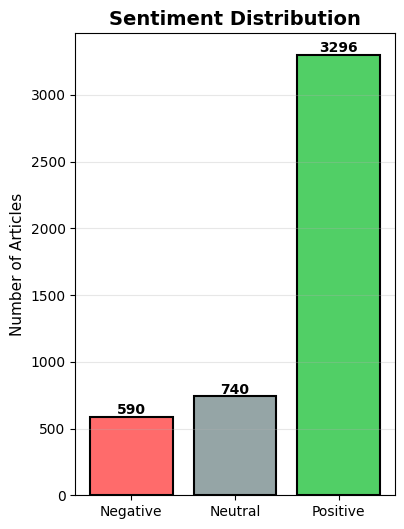

In [ ]:
# Visualize distributions
plt.figure(figsize=(14, 6))

# Plot 1: Sentiment distribution
plt.subplot(1, 3, 1)
colors = ['#ff6b6b', '#95a5a6', '#51cf66']
bars = plt.bar(
    ['Negative', 'Neutral', 'Positive'],
    [sentiment_counts.get(-1, 0), sentiment_counts.get(0, 0), sentiment_counts.get(1, 0)],
    color=colors,
    edgecolor='black',
    linewidth=1.5
)
plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Articles', fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')


In [ ]:
# Save enriched articles data
output_file = '../exports/articles_with_sentiment.json'

enriched_data = {
    'metadata': {
        'total_articles': len(articles),
        'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_used': 'xlm-roberta-tunisian-finance',
        'sentiment_distribution': {
            'negative': int(sentiment_counts.get(-1, 0)),
            'neutral': int(sentiment_counts.get(0, 0)),
            'positive': int(sentiment_counts.get(1, 0))
        },
        'confidence_distribution': {
            'high': int(confidence_counts.get('high', 0)),
            'medium': int(confidence_counts.get('medium', 0)),
            'low': int(confidence_counts.get('low', 0))
        }
    },
    'articles': articles
}

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(enriched_data, f, ensure_ascii=False, indent=2)

print(f"\n✅ Enriched articles saved to: {output_file}")
print(f"   Total size: {len(json.dumps(enriched_data, ensure_ascii=False))} bytes")


✅ Enriched articles saved to: ../exports/articles_with_sentiment.json
   Total size: 10677759 bytes


In [ ]:
# Generate ticker-level sentiment aggregation
print("\n" + "="*60)
print("GENERATING TICKER-LEVEL SIGNALS")
print("="*60)

ticker_sentiments = {}

for article in articles:
    # Extract tickers (handle different formats)
    tickers = article.get('tickers', [])
    
    # Convert to list if string
    if isinstance(tickers, str):
        if tickers:
            tickers = [t.strip() for t in tickers.split(',')]
        else:
            tickers = []
    elif not isinstance(tickers, list):
        tickers = []
    
    sentiment = article['sentiment_score']
    confidence = article['confidence']
    date = article.get('date', '')
    
    for ticker in tickers:
        ticker = ticker.strip()
        if not ticker:
            continue
            
        if ticker not in ticker_sentiments:
            ticker_sentiments[ticker] = {
                'ticker': ticker,
                'positive_count': 0,
                'neutral_count': 0,
                'negative_count': 0,
                'total_articles': 0,
                'net_sentiment': 0.0,
                'high_confidence_count': 0,
                'recent_articles': []
            }
        
        stats = ticker_sentiments[ticker]
        stats['total_articles'] += 1
        
        # Count by sentiment
        if sentiment == 1:
            stats['positive_count'] += 1
        elif sentiment == -1:
            stats['negative_count'] += 1
        else:
            stats['neutral_count'] += 1
        
        # Track confidence
        if confidence == 'high':
            stats['high_confidence_count'] += 1
        
        # Store recent article info
        stats['recent_articles'].append({
            'date': date,
            'headline': article.get('headline', '')[:100],
            'sentiment': labels_map[sentiment],
            'confidence': confidence
        })

# Calculate net sentiment scores
for ticker, stats in ticker_sentiments.items():
    if stats['total_articles'] > 0:
        # Net sentiment: (positive - negative) / total
        stats['net_sentiment'] = round(
            (stats['positive_count'] - stats['negative_count']) / stats['total_articles'],
            3
        )
        
        # Keep only 5 most recent articles
        stats['recent_articles'] = sorted(
            stats['recent_articles'],
            key=lambda x: x['date'],
            reverse=True
        )[:5]

print(f"✓ Analyzed {len(ticker_sentiments)} unique tickers")


GENERATING TICKER-LEVEL SIGNALS
✓ Analyzed 90 unique tickers


In [ ]:
# Export ticker signals to JSON
signals_output = '../exports/ticker_sentiment_signals.json'

ticker_signals = {
    'generated_at': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model': 'xlm-roberta-tunisian-finance',
    'total_tickers': len(ticker_sentiments),
    'total_articles_analyzed': len(articles),
    'tickers': ticker_sentiments
}

with open(signals_output, 'w', encoding='utf-8') as f:
    json.dump(ticker_signals, f, ensure_ascii=False, indent=2)

print(f"✅ Ticker signals saved to: {signals_output}")

✅ Ticker signals saved to: ../exports/ticker_sentiment_signals.json


In [ ]:
# Display top tickers by net sentiment
print("\n" + "="*80)
print("TOP 10 TICKERS BY NET SENTIMENT")
print("="*80)

sorted_tickers = sorted(
    ticker_sentiments.items(),
    key=lambda x: x[1]['net_sentiment'],
    reverse=True
)

for i, (ticker, stats) in enumerate(sorted_tickers[:10], 1):
    print(f"\n{i}. {ticker}")
    print(f"   Total Articles: {stats['total_articles']}")
    print(f"   Positive: {stats['positive_count']} | Neutral: {stats['neutral_count']} | Negative: {stats['negative_count']}")
    print(f"   Net Sentiment: {stats['net_sentiment']:+.3f}")
    print(f"   High Confidence: {stats['high_confidence_count']}/{stats['total_articles']}")

print("\n" + "="*80)
print("BOTTOM 5 TICKERS BY NET SENTIMENT")
print("="*80)

for i, (ticker, stats) in enumerate(sorted_tickers[-5:], 1):
    print(f"\n{i}. {ticker}")
    print(f"   Total Articles: {stats['total_articles']}")
    print(f"   Positive: {stats['positive_count']} | Neutral: {stats['neutral_count']} | Negative: {stats['negative_count']}")
    print(f"   Net Sentiment: {stats['net_sentiment']:+.3f}")


TOP 10 TICKERS BY NET SENTIMENT

1. BEST LEASE
   Total Articles: 13
   Positive: 13 | Neutral: 0 | Negative: 0
   Net Sentiment: +1.000
   High Confidence: 0/13

2. ATTIJARI LEASING
   Total Articles: 24
   Positive: 23 | Neutral: 1 | Negative: 0
   Net Sentiment: +0.958
   High Confidence: 0/24

3. SPDIT - SICAF
   Total Articles: 13
   Positive: 12 | Neutral: 1 | Negative: 0
   Net Sentiment: +0.923
   High Confidence: 0/13

4. WIFAK INT BANK
   Total Articles: 118
   Positive: 103 | Neutral: 11 | Negative: 4
   Net Sentiment: +0.839
   High Confidence: 0/118

5. ARAB TUNISIAN LEASE
   Total Articles: 70
   Positive: 59 | Neutral: 9 | Negative: 2
   Net Sentiment: +0.814
   High Confidence: 0/70

6. TUNISIE LEASING & FACTORING
   Total Articles: 70
   Positive: 60 | Neutral: 7 | Negative: 3
   Net Sentiment: +0.814
   High Confidence: 0/70

7. CIL
   Total Articles: 26
   Positive: 21 | Neutral: 4 | Negative: 1
   Net Sentiment: +0.769
   High Confidence: 0/26

8. NEW BODY LINE
   